In [48]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm, trange

In [49]:
data_dir = Path("/home/sibwang/Projects/flygym/outputs/path_integration")
pkl_paths = list(data_dir.glob("random_walk_seed*.pkl"))

In [50]:
# def process_one_file(path, w, tau):
path = pkl_paths[0]
w = 0.1
tau = 0.05

In [51]:
with open(path, "rb") as f:
    data = pickle.load(f)

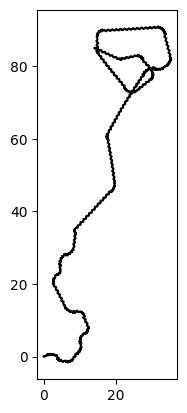

In [52]:
xy = np.array([obs["fly"][0, :2] for obs in data["obs_hist"]])
plt.plot(xy[:, 0], xy[:, 1], "k", alpha=1)
plt.gca().set_aspect("equal")

In [82]:
np.sqrt(np.sum(np.diff(xy, axis=0) ** 2, axis=1)).sum()

343.98352

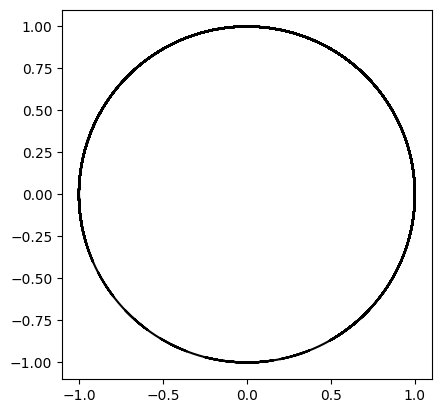

In [53]:
heading = np.array([obs["fly_orientation"][:2] for obs in data["obs_hist"]])
plt.plot(heading[:, 0], heading[:, 1], "k", alpha=1)
plt.gca().set_aspect("equal")

In [56]:
data["obs_hist"][0]["end_effectors"]

array([[ 1.9554878 ,  0.22396538,  1.6168456 ],
       [-0.0648431 ,  2.2430058 ,  1.2158736 ],
       [-2.2431293 ,  1.2230865 ,  1.2066264 ],
       [ 1.9555252 , -0.22392924,  1.6170012 ],
       [-0.05918881, -2.2414842 ,  1.2174224 ],
       [-2.2425501 , -1.2233745 ,  1.2061124 ]], dtype=float32)

In [57]:
fly_orientation_hist = np.array([obs["fly_orientation"] for obs in data["obs_hist"]])

In [58]:
end_effector_diff_hist = np.array([info["ee_diff"] for info in data["info_hist"]])

In [59]:
ee_pos_hist = np.array([obs["end_effectors"] for obs in data["obs_hist"]])

-79.50841
-114.42055
-97.37384
-100.0449
-137.7396
-133.05942


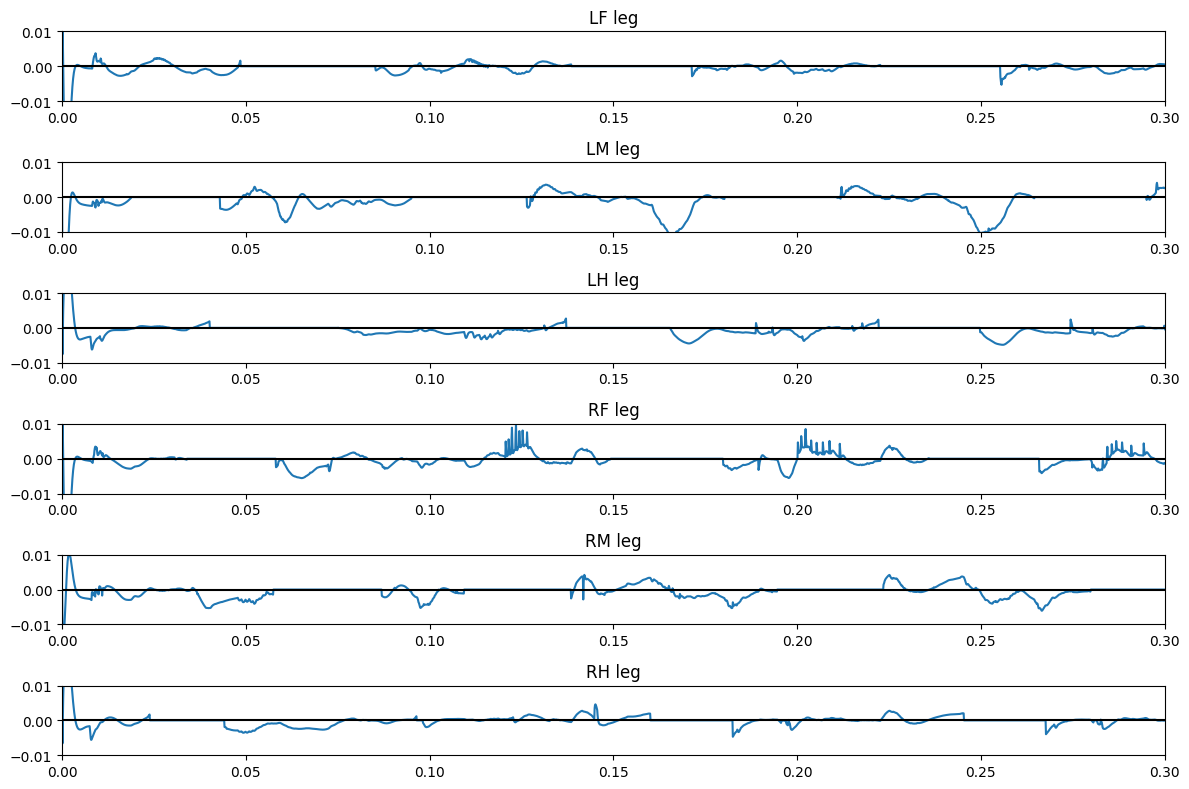

In [75]:
t_grid = np.arange(len(fly_orientation_hist)) * 1e-4
fig, axs = plt.subplots(6, 1, figsize=(12, 8), tight_layout=True)
for i, leg in enumerate(["LF", "LM", "LH", "RF", "RM", "RH"]):
    ts = end_effector_diff_hist[:, i, 0]
    print(np.sum(ts))
    axs[i].plot(t_grid, ts, label="x")
    axs[i].set_title(f"{leg} leg")
    axs[i].set_ylim([-0.01, 0.01])
    axs[i].set_xlim(0, 0.3)
    axs[i].axhline(0, color="k", linestyle="-")

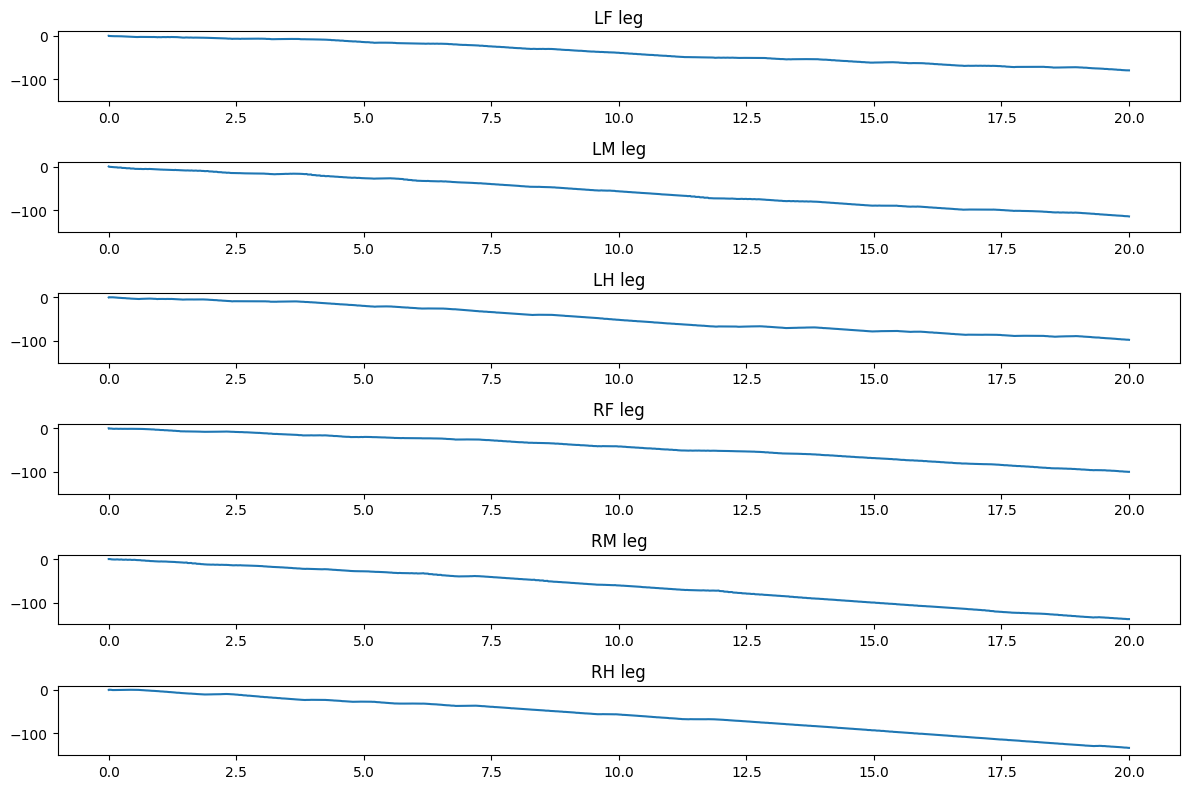

In [85]:
t_grid = np.arange(len(fly_orientation_hist)) * 1e-4
fig, axs = plt.subplots(6, 1, figsize=(12, 8), tight_layout=True)
for i, leg in enumerate(["LF", "LM", "LH", "RF", "RM", "RH"]):
    ts = end_effector_diff_hist[:, i, 0]
    axs[i].plot(t_grid, np.cumsum(ts), label="x")
    axs[i].set_title(f"{leg} leg")
    axs[i].set_ylim([-150, 10])

In [179]:
heading_angle_hist = np.arctan2(fly_orientation_hist[:, 1], fly_orientation_hist[:, 0])

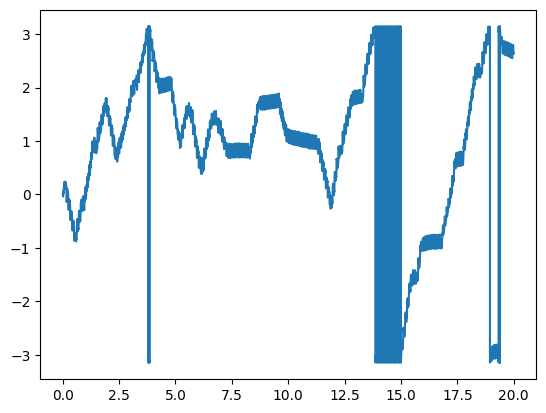

In [180]:
plt.plot(t_grid, heading_angle_hist)

In [181]:
def calculate_proprio_heading_diffs(window_size: float = 0.1, dt: float = 1e-4):
    window_steps = int(window_size / dt)

    left_total = np.cumsum(end_effector_diff_hist[:, :3, 0].sum(axis=1))
    right_total = np.cumsum(end_effector_diff_hist[:, 3:, 0].sum(axis=1))
    left_right_diff = left_total - right_total
    proprio_asym_diff = left_right_diff[window_steps:] - left_right_diff[:-window_steps]

    heading_diff = (
        heading_angle_hist[window_steps:] - heading_angle_hist[:-window_steps]
    )
    heading_diff = (heading_diff + np.pi) % (2 * np.pi) - np.pi

    return proprio_asym_diff, heading_diff

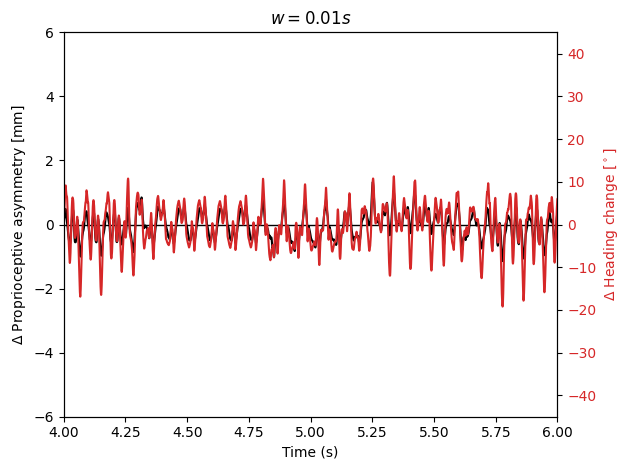

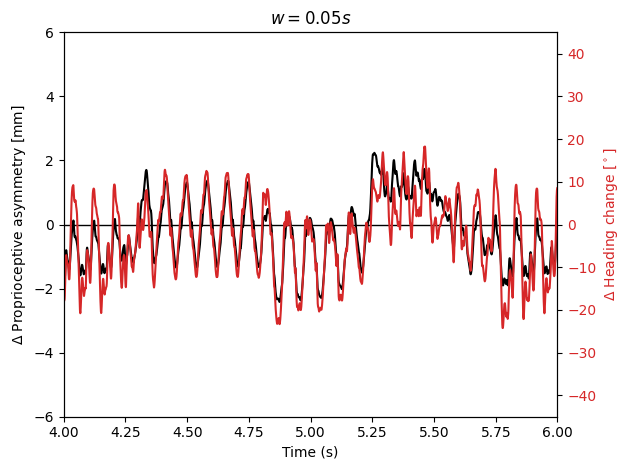

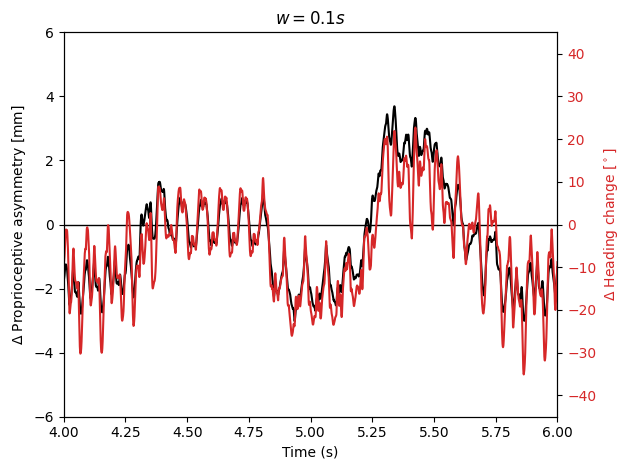

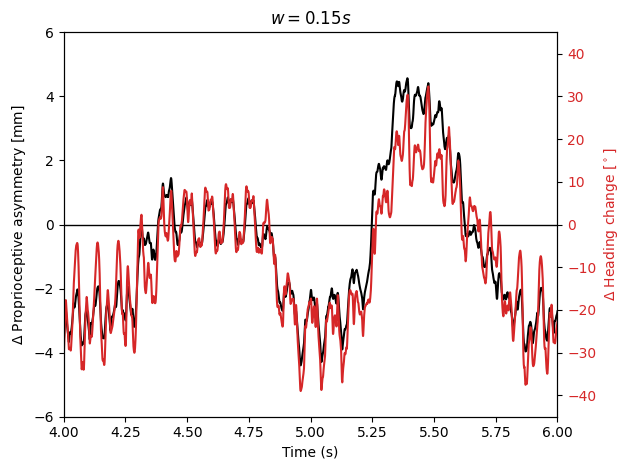

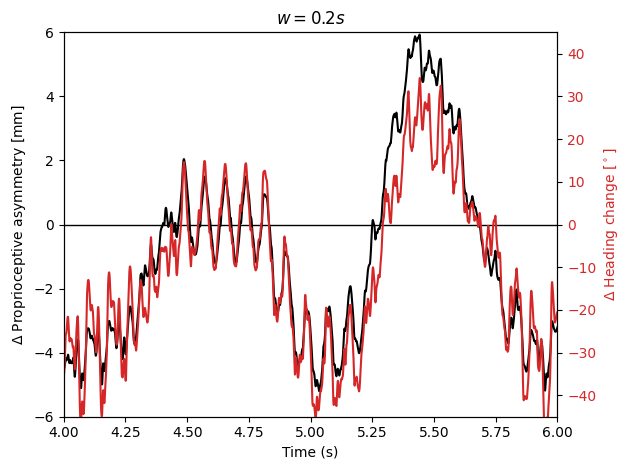

In [186]:
for window_size in [0.01, 0.05, 0.1, 0.15, 0.2]:
    window_steps = int(window_size / 1e-4)

    proprio_asym_diff, heading_diff = calculate_proprio_heading_diffs(window_size)
    fig, ax0 = plt.subplots()
    plt.axhline(0, color="k", linestyle="-", lw=1)

    # proprioception
    prop_color = "black"
    ax0.plot(t_grid[window_steps:], proprio_asym_diff, color=prop_color)
    ax0.set_xlabel("Time (s)")
    ax0.set_ylabel("$\Delta$ Proprioceptive asymmetry [mm]", color=prop_color)
    ax0.tick_params(axis="y", labelcolor=prop_color)
    ax0.set_xlim(4.0, 6.0)
    ax0.set_ylim(-6, 6)

    # heading
    heading_color = "tab:red"
    ax1 = ax0.twinx()
    ax1.plot(t_grid[window_steps:], np.rad2deg(heading_diff), color=heading_color)
    ax1.set_ylabel("$\Delta$ Heading change [$^\circ$]", color=heading_color)
    ax1.tick_params(axis="y", labelcolor=heading_color)
    ax1.set_ylim(-45, 45)

    ax1.set_title(f"$w={window_size}s$")
    fig.tight_layout()
    plt.show()

(-35.0, 35.0)

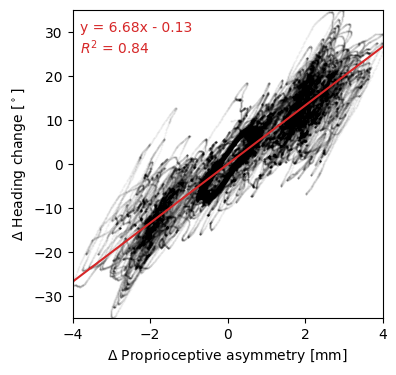

In [205]:
window_size = 0.1
window_steps = int(window_size / 1e-4)
proprio_asym_diff, heading_diff = calculate_proprio_heading_diffs(window_size)
k_rad, b_rad = np.polyfit(proprio_asym_diff, heading_diff, 1)
k_deg, b_deg = np.rad2deg([k_rad, b_rad])
model_rad = np.poly1d([k_rad, b_rad])
model_deg = np.poly1d([k_deg, b_deg])
y_pred = model_rad(proprio_asym_diff)
ss_res = np.sum((heading_diff - y_pred) ** 2)
ss_tot = np.sum((heading_diff - np.mean(heading_diff)) ** 2)
r2 = 1 - (ss_res / ss_tot)

xs = np.array([-10, 10])
ys = model_deg(xs)
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(
    proprio_asym_diff, np.rad2deg(heading_diff), s=1, marker=".", alpha=0.05, color="k"
)
ax.plot(xs, ys, "tab:red")
text = (
    f"y = {k_deg:.2f}x {'+' if b_deg > 0 else '-'} {abs(b_deg):.2f}\n$R^2$ = {r2:.2f}"
)
ax.text(-3.8, 25, text, fontsize=10, color="tab:red")
ax.set_xlabel("$\Delta$ Proprioceptive asymmetry [mm]")
ax.set_ylabel("$\Delta$ Heading change [$^\circ$]")
ax.set_xlim(-4, 4)
ax.set_ylim(-35, 35)

In [206]:
heading_diff_pred = model_rad(proprio_asym_diff)

Text(0, 0.5, '$\\Delta$heading [$^\\circ$]')

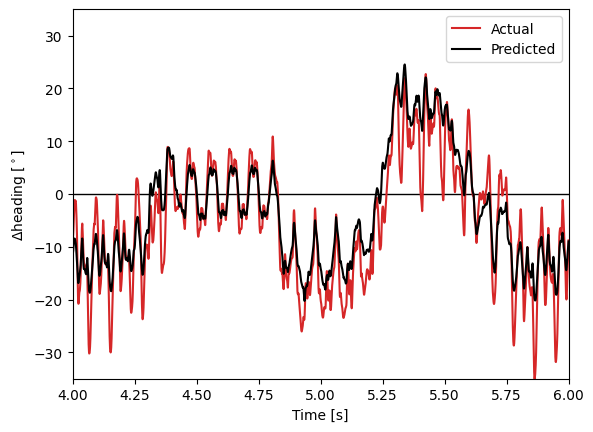

In [230]:
plt.axhline(0, color="k", linestyle="-", lw=1)
plt.plot(
    t_grid[window_steps:],
    np.rad2deg(heading_diff),
    color="tab:red",
    label="Actual",
)
plt.plot(
    t_grid[window_steps:],
    np.rad2deg(heading_diff_pred),
    color="black",
    label="Predicted",
)
plt.legend()
plt.xlim(4.0, 6.0)
plt.ylim(-35, 35)
plt.xlabel("Time [s]")
plt.ylabel("$\Delta$heading [$^\circ$]")

Text(0, 0.5, 'Heading (unwrapped) [$^\\circ$]')

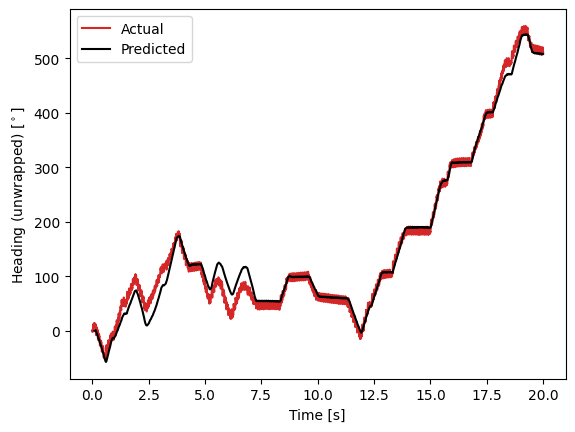

In [232]:
# real_heading_cumsum = np.cumsum(heading_diff / window_steps)
pred_heading_cumsum = np.cumsum(heading_diff_pred / window_steps)
# plt.plot(real_heading_cumsum)
plt.plot(
    t_grid,
    np.rad2deg(np.unwrap(heading_angle_hist)),
    color="tab:red",
    label="Actual",
)
plt.plot(
    t_grid[window_steps:],
    np.rad2deg(pred_heading_cumsum),
    color="black",
    label="Predicted",
)
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Heading (unwrapped) [$^\circ$]")